# Симуляция CTR

В своём прошлом проекте про конверсию я рассказывал, что у неё есть злой брат-близнец по имени CTR. Давайте разберёмся, что же это такое - и попробуем понять, чем же эта штука так отличается от обыкновенной конверсии и почему с её анализом надо быть аккуратнее.

Мой прошлый ноутбук оказался чудовищно гигантским. Поэтому я попробую разбить свои рассуждения на четыре части - авось так их будет читать попроще. 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=2112)

## Что такое CTR?

На первый взгляд различия между конверсией и CTR кажутся минимальными - просто в случае конверсии у нас один пользователь-одно событие, а тут у нас один пользователь-несколько событий. Будто бы ничего особенного, правда?

По факту же CTR относится к классу метрик, называемых **метриками-отношениями (ratio metrics)**. Как и подсказывает название, это метрики, являющиеся отношением двух других метрик. Архетипичный случай можно описать так:

$$CTR = \frac{clicks}{views}$$

т.е. отношение числа *кликов* к *просмотрам* - имеются в виду просмотры некоторых объявлений и нажатия пользователей на эти объявления. Само собой, события необязательно должны быть именно такими - вместо клика на объявление у нас может быть, например, *лайк* поста в соцсетях. Главное, чтобы метрики соответствовали следующим условиям:

1. В их основе должно лежать некоторое бинарное событие - что-то произошло или что-то не произошло.
2. Отношение находится в диапазоне значений от 0 до 1 - иными словами, метрика в числителе не должна превышать метрику в знаменателе.

Что мы можем сказать с ходу о поведении такой метрики?

* Она линейно зависит от числителя. При постоянном знаменателе изменение числа кликов/лайков на некоторую величину взаимооднозначно изменит и сам CTR.
* В то же время она нелинейно зависит от знаменателя - с ростом знаменателя CTR меняется согласно обратной функции:

$$y = \frac{1}{views}$$

Чтобы наглядно представить, что это для нас означает, давайте нарисуем график этой функции в диапазоне от 1 до 1000:

<Axes: >

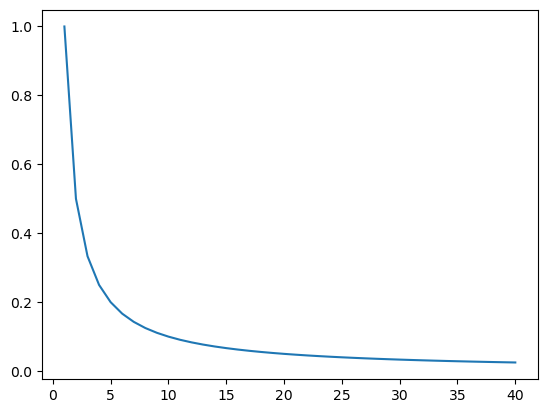

In [2]:
sns.lineplot(x=np.arange(1., 41.), y=np.reciprocal(np.arange(1., 41.)))

Это нелинейная функция - чем больше значение знаменателя, тем слабее влияет его прирост на значение CTR. Прирост от 9 до 10 просмотров отразится на значении CTR серьёзнее, чем прирост от 999 до 1000.

* Между обеими метриками есть *мультипликативная взаимосвязь* - т.е. итоговый результат является следствием произведения:

$$CTR = clicks * \frac{1}{views}$$

Из этого есть два следствия: а) сила воздействия числителя на CTR зависит от значения знаменателя б) один и тот же CTR может получиться при самых разных значениях числителя и знаменателя. 

* Так как числитель никогда не может превысить знаменатель, метрики в них имеют ненулевую корреляцию. Если у нас всего 10 просмотров, то выше 10 кликов мы не наберём никогда.
* Так как на одного пользователя приходится несколько действий, метрики содержат в себе **зависимые наблюдения** - какие-то пользователи кликают чаще, какие-то реже. Это имеет важное значение для статистического анализа, так как многие классические методы предполагают **независимость наблюдений**.

Вот вам и "всего лишь небольшое отличие от конверсии"! CTR реально находится в отдельной категории. А чтобы это прочувствовать в полной мере, давай попробуем просимулировать CTR своими руками.

> Затравочка: у нас есть 50 постов в некоторой соцсети. Пользователи видят эти посты и лайкают их. Наша задача - посчитать CTR, т.е. в данном случае отношение числа лайков к числу просмотров.

## Число просмотров

Начнём со знаменателя. Первая очевидная мысль - вряд ли пользователи увидят все 50 наших постов; кто-то увидит пост, кто-то не увидит, кто-то больше, кто-то меньше. Соответственно, мы возвращаемся к старому знакомому - биномиальному распределнию.

Давайте предположим, что вероятность увидеть пост составляет 50%. Соответственно, мы можем вот так нагенерировать количесство постов, которое увидел каждый из пользователей:

In [3]:
bin_views = rng.binomial(n=50, p=0.5, size=10000)
bin_views[0:10]

array([20, 28, 20, 27, 20, 23, 25, 26, 22, 29], dtype=int64)

Посмотрим, что получилось:

Среднее: 24.9719
Стандартное отклонение: 3.500044341147695


<Axes: ylabel='Count'>

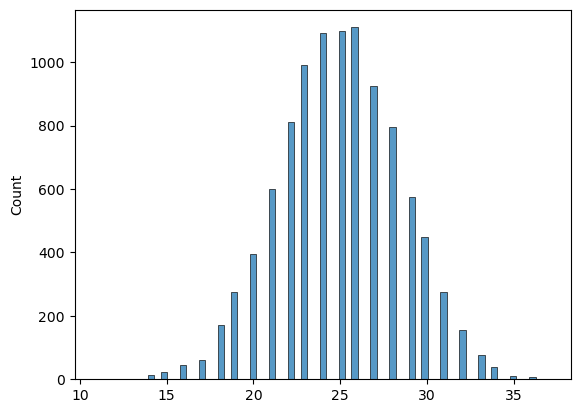

In [4]:
print(f"Среднее: {np.mean(bin_views)}")
print(f"Стандартное отклонение: {np.std(bin_views)}")

sns.histplot(bin_views)

**Красота! Вот мы и получили распределение просмотров!** - могли бы сказать мы, если бы не одно но. Мы действительно думаем, что у каждого пользователя одинаковая вероятность увидеть посты? Наверняка у нас есть пользователи, которые регулярно лазают по соцсетям и потенциально видят кучу постов - равно как и пользователи, которые не настолько активны и имеют изначально более редкий шанс что-то увидеть. Как нам учесть такую ситуацию?

И вот здесь на сцену выходит **бета-распределение**.

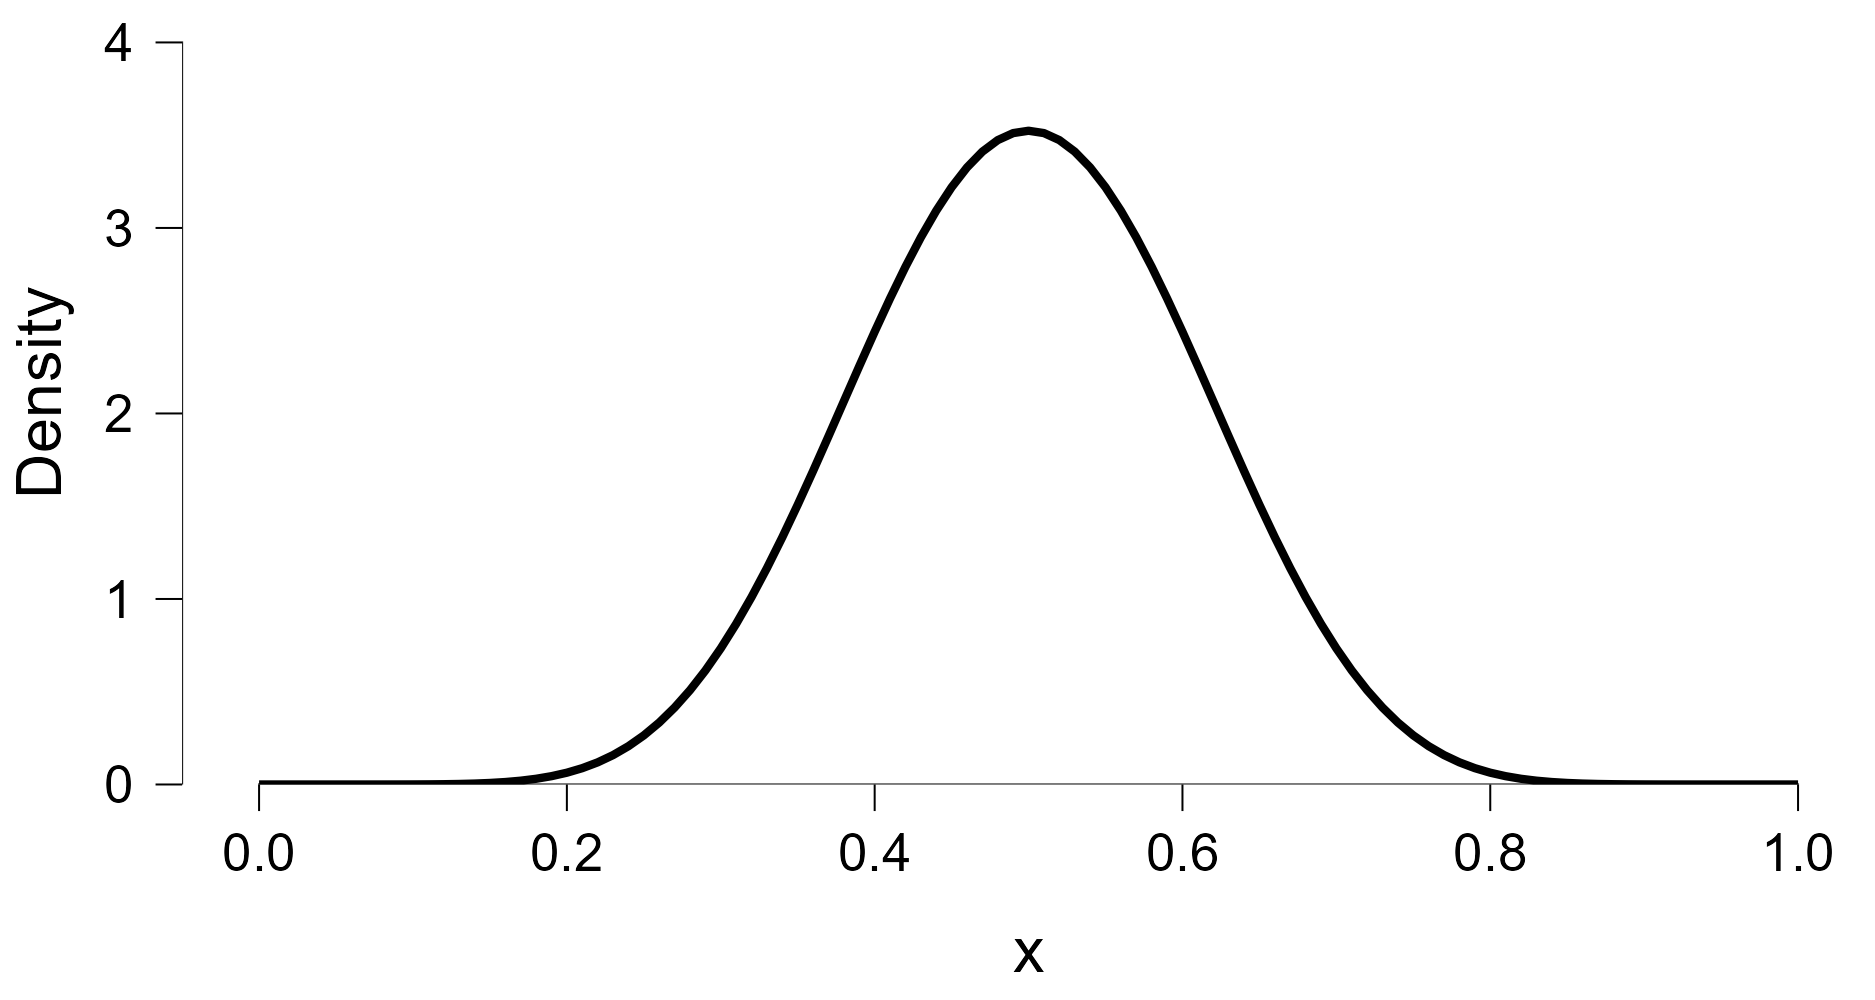

Это распределение определено в диапазоне от 0 до 1 (обе границы невключительно) - и поэтому оно очень хорошо подходит для симуляции распределения вероятностей! У него есть два параметра - $\alpha$ и $\beta$. Первый можно условно интерпретировать как число успехов, а второй - как число неудач. Путём этого мы можем менять центральную тенденцию, дисперсию и форму распределения. 

Давайте попробуем сгенерировать данные из бета-распределения с $\alpha = 10$ и $\beta = 10$. Чтобы понять, как оно будет выглядеть, нам потребуется так называемая **функция плотности вероятности (probability density function, PDF)** - она принимает на вход некоторое число и возвращает его плотность вероятности в распределении с заданными параметрами.

Вот так она используется - мы даём на вход последовательность чисел от 0.01 до 0.99 с шагом 0.01, получаем плотность вероятности каждого из этих чисел в бета-распределении с $\alpha = 10$ и $\beta = 10$:

In [5]:
st.beta.pdf(np.arange(0.01, 1.0, 0.01), 10, 10)[0:10]

array([8.43888963e-13, 3.94342148e-10, 1.38231002e-08, 1.67706376e-07,
       1.13713242e-06, 5.33433752e-06, 1.93998089e-05, 5.85421792e-05,
       1.53152352e-04, 3.57891299e-04])

Нарисуем:

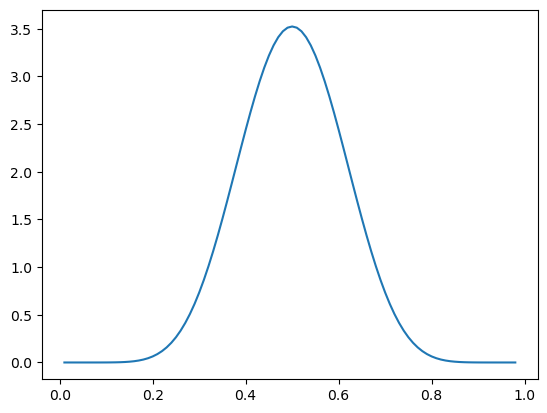

In [6]:
plt.plot(np.arange(0.01, 0.99, 0.01), st.beta.pdf(np.arange(0.01, 0.99, 0.01), 10, 10))

Мы видим, что распределение центрировано в значении вероятности 0.5 - однако есть отклонения в обе стороны. Эти вероятности мы можем использовать для генерации числа просмотров; к счастью, в этом нам также поможет функция `binomial`. Она может принять на вход не одно значение вероятности, а сразу несколько - и сгенерировать результаты отдельно для каждого:

In [7]:
probs_views = rng.beta(a=10, b=10, size=10000)
betabin_views = rng.binomial(n=50, p=probs_views)

print(probs_views[0:10])
print(betabin_views[0:10])

[0.39963712 0.52006209 0.38580031 0.34377204 0.40325066 0.49657548
 0.51901201 0.60105419 0.54185973 0.71761044]
[20 27 17 15 17 26 27 31 23 32]


Ну и давайте посмотрим, что у нас вышло теперь:

Среднее: 25.0511
Стандартное отклонение: 6.483786608919205


<Axes: ylabel='Count'>

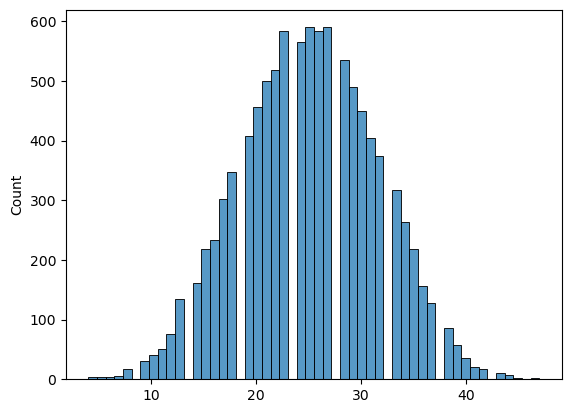

In [8]:
print(f"Среднее: {np.mean(betabin_views)}")
print(f"Стандартное отклонение: {np.std(betabin_views)}")

sns.histplot(betabin_views)

Видим, что форма распределения осталась неизменной, как и его среднее - однако стандартное отклонение выросло почти вдвое! Теперь у нас гораздо большая изменчивость числа просмотров, чем была раньше, и это гораздо больше похоже на реальность.

Процедура, которую мы выполнили выше, настолько хорошо известна, что получившееся распределение даже имеет своё имя - **бета-биномиальное распределение**:

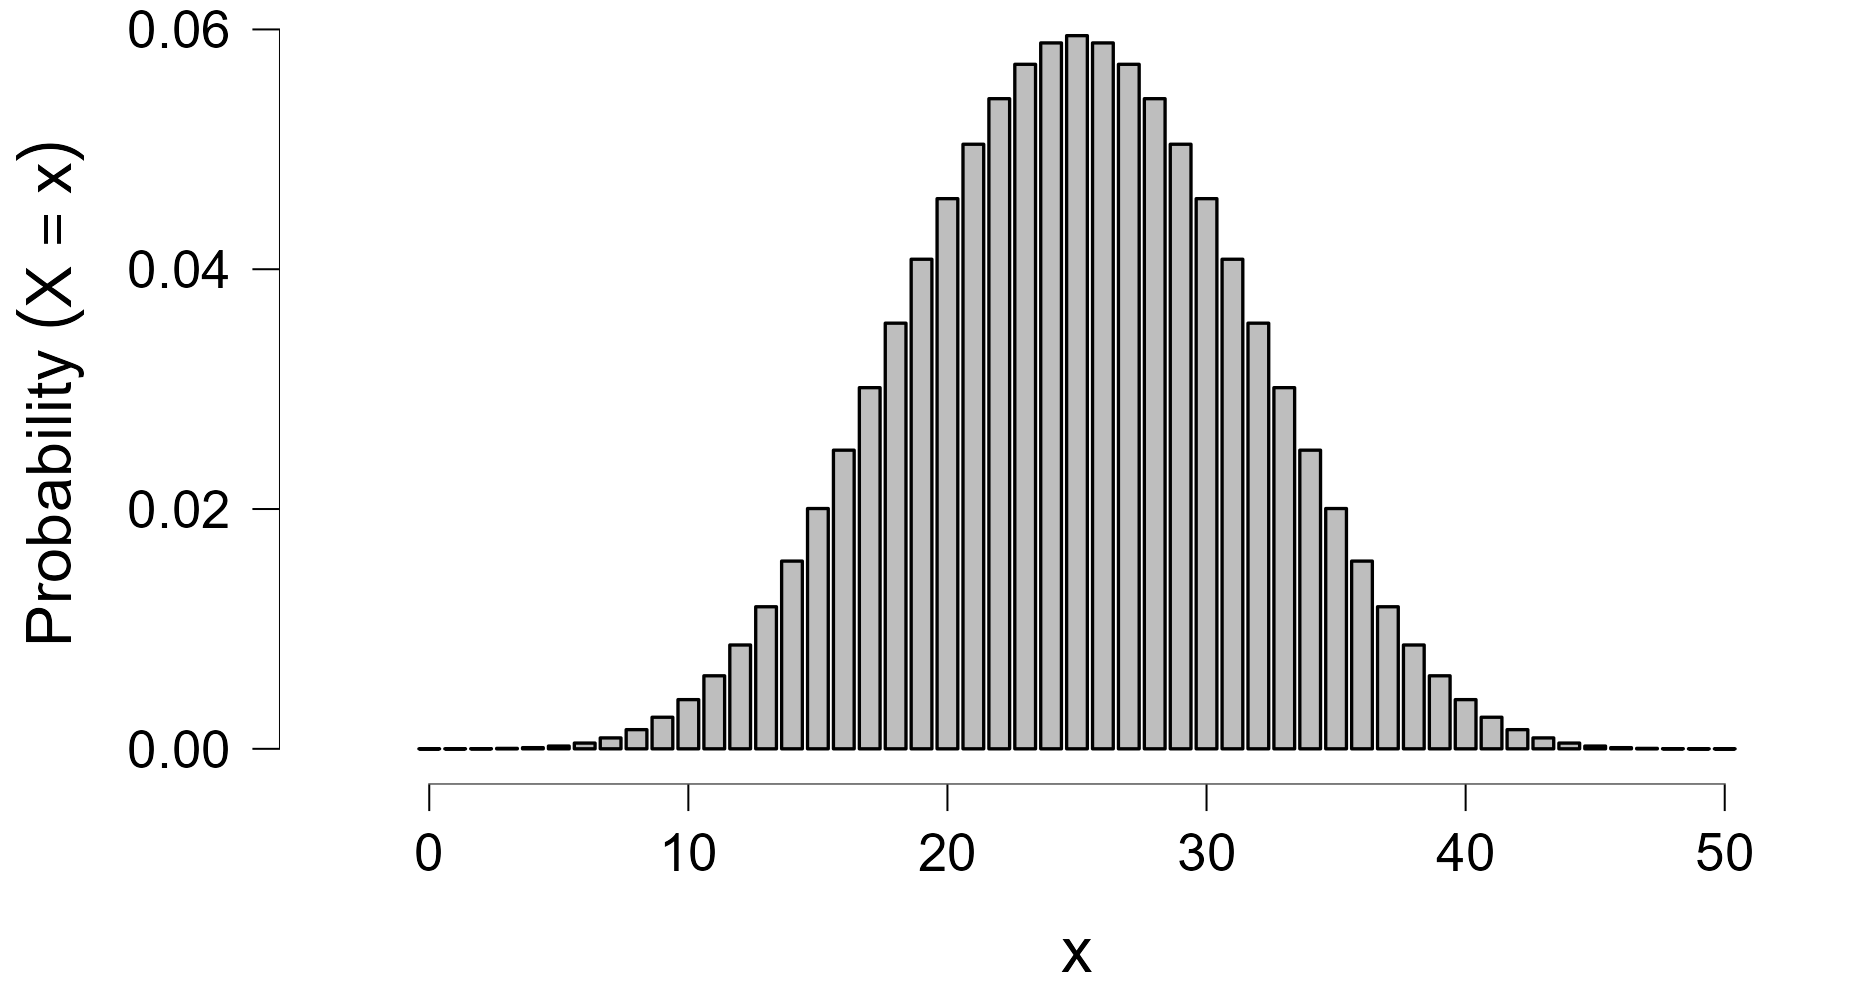

Более того, в `scipy` для него есть отдельная функция, которая позволяет нам записать всё использованное выше более коротко:

Среднее: 25.091
Стандартное отклонение: 6.385665118059355


<Axes: ylabel='Count'>

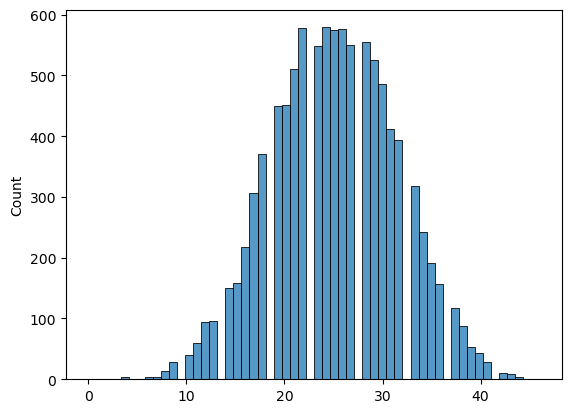

In [9]:
betabin_views = st.betabinom.rvs(n=50, a=10, b=10, size=10000)

print(f"Среднее: {np.mean(betabin_views)}")
print(f"Стандартное отклонение: {np.std(betabin_views)}")

sns.histplot(betabin_views)

Результаты, как видите, всё те же. Однако имеет ли смысл использовать именно эту функцию? Чтобы это понять, давайте посмотрим на скорость генерации данных каждым из двух способов:

In [10]:
%timeit st.betabinom.rvs(n=50, a=10, b=10, size=10000)

2.3 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
%timeit rng.binomial(n=50, p=rng.beta(a=10, b=10, size=10000), size=10000)

1.99 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Упс. Кажется, что нампаевский вариант быстрее. Учитывая, что в будущем нас ждёт много повторных симуляций, я бы остановился на более быстром варианте.

Итак, распределение числа просмотров готово. Давайте разбираться с числом лайков.

## Число лайков

С числом лайков работаем по той же схеме. Опять же, наверняка у разных пользователей будут разные интересы, разные паттерны поведения и разные вероятности поставить лайк! Так что снова привлекаем бета-распределение - в этот раз с $\alpha = 5$ и $\beta = 20$:

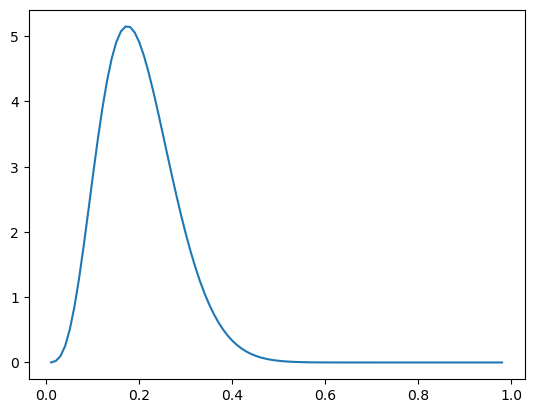

In [12]:
plt.plot(np.arange(0.01, 0.99, 0.01), st.beta.pdf(np.arange(0.01, 0.99, 0.01), 5, 20))

В этот раз центр распределения сместился в сторону вероятности 0.2, но отклонения от этого центра всё ещё есть, и довольно выраженные.

А теперь внимание. Помните, что количество лайков зависит от числа просмотров? Это значит, что нам стоит учесть количество просмотров при генерации данных. К счастью, `numpy` позволяет нам это сделать - просто указываем в качестве аргумента `n` не одно значение, а несколько. Туда мы и подадим количество просмотров у каждого пользователя:

Среднее: 5.0487
Стандартное отклонение: 3.110486828456279


<Axes: ylabel='Count'>

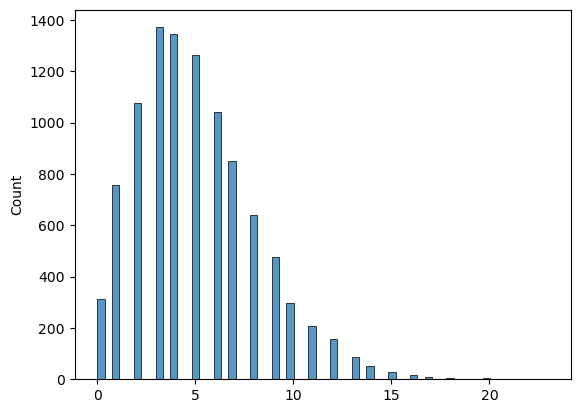

In [13]:
betabin_likes = rng.binomial(n=betabin_views, p=rng.beta(a=5, b=20, size=10000))

print(f"Среднее: {np.mean(betabin_likes)}")
print(f"Стандартное отклонение: {np.std(betabin_likes)}")

sns.histplot(betabin_likes)

Вот такое у нас вышло ассиметричное распределение лайков! Давайте поглядим на корреляцию:

Корреляция Пирсона:0.4103540401100878


<Axes: >

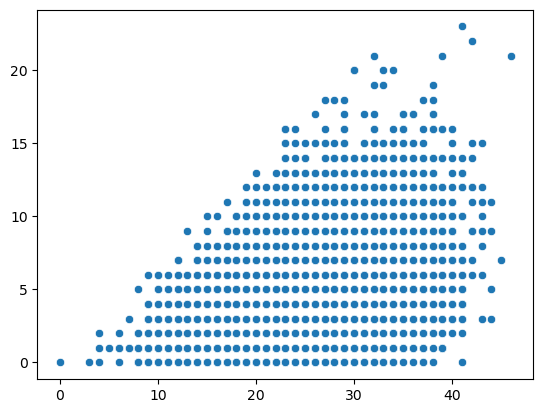

In [14]:
print(f"Корреляция Пирсона:{st.pearsonr(x=betabin_views, y=betabin_likes)[0]}")

sns.scatterplot(x=betabin_views, y=betabin_likes)

Видим, что выраженная корреляция определённо есть! Хоть и не идеальная - видно, что вариабельность всё ещё довольно мощная, в данных происходит много чего другого.

Замечу, что если бы у нас была бы необходимость сгенерировать не агрегированные количества лайков и просмотров, а "сырую" последовательность 0 и 1, то мы могли бы просто много раз запустить функцию binomial с параметром n=1 (так как распределение Бернулли) и варьирующими в цикле значениями вероятности и числа просмотров, а потом объединить их в один массив.

Я реализовал это вот так: благодаря функции [zip()](https://pythoner.name/zip) я итерируюсь в цикле одновременно по двум массивам (лайки и просмотры), благодря [list comprehension](https://dvmn.org/encyclopedia/qna/5/chto-takoe-list-comprehension-zachem-ono-kakie-esche-byvajut/) цикл пишется в одну строчку и сразу же укладывается в список, а благодаря функции [concatenate()](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) весь список объединяется в единый массив. Вот и получились "сырые" данные!

In [15]:
probs_likes = rng.beta(a=5, b=20, size=10000)

np.concatenate([rng.binomial(n=1, p=p, size=size) for p, size in zip(probs_likes, betabin_views)])

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

Вот это мы с вами знатный путь прошли. Чтобы его завершить, ниже я прикладываю две функции для генерации данных, на которых можно считать CTR - в агрегированном и "сыром" виде.

## Общие функции для генерации данных

Пара дополнительных комментариев:

1. Так как мы будем имитировать А/Б-тесты, то я сразу же встроил в функцию возможность добавлять эффект. В данном случае предполагается, что воздействуем мы на лайки, поэтому меняем мы вероятности лайков.
2. Эффект я решил выбрать *мультипликативный* - т.е. я не прибавляю что-то к вероятности, а умножаю на некоторый коэффициент. По умолчанию он будет равен 1.0, т.е. не будет оказывать никакого эффекта - но при симуляциях мы будем это число менять, чтобы симулировать увеличение вероятности лайка в n-ое число раз.
3. В первой функции у меня ещё считается *пользовательский CTR* - т.е. отношение лайков к просмотрам у конкретного пользователя. При желании это можно убрать, но в следующем ноутбуке этот расчёт мне пригодится для демонстрации очень важной вещи.

In [16]:
def generate_ctr_agg(rng, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, multiplier=1.0):

    #генерируем вероятности просмотров
    p_views=rng.beta(a=a_views, b=b_views, size=n)
    #генерируем вероятности лайков (и делаем мультипликативный сдвиг)
    p_likes=rng.beta(a=a_likes, b=b_likes, size=n) * multiplier

    #генерируем количество просмотренных постов каждым пользователем
    views = rng.binomial(n=total_posts, p=p_views, size=n)
    #генерируем количество поставленных лайков каждым пользователем
    likes = rng.binomial(n=views, p=p_likes, size=n)

    #возвращаем датафрейм
    return(pd.DataFrame({"user":np.arange(0, n, 1), "views":views, "likes":likes, "user_ctr":likes/views}))

In [17]:
generate_ctr_agg(np.random.default_rng(seed=2112)) 

,user,views,likes,user_ctr
0,0,30,4,0.133333
1,1,34,4,0.117647
2,2,19,4,0.210526
3,3,19,8,0.421053
4,4,21,3,0.142857
...,...,...,...,...
995,995,25,0,0.000000
996,996,27,9,0.333333
997,997,20,4,0.200000
998,998,16,3,0.187500


In [18]:
def generate_ctr_raw(rng, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, multiplier=1.0):

    #генерируем вероятности просмотров
    p_views=rng.beta(a=a_views, b=b_views, size=n)
    #генерируем вероятности лайков (и делаем мультипликативный сдвиг)
    p_likes=rng.beta(a=a_likes, b=b_likes, size=n) * multiplier

    #генерируем количество просмотренных постов каждым пользователем
    views = rng.binomial(n=total_posts, p=p_views, size=n)
    #генерируем событие лайка-нелайка для каждого пользователя
    likes = np.concatenate([rng.binomial(n=1, p=p, size=size) for p, size in zip(p_likes, views)])

    #айдишники пользователей
    user_ids = np.arange(0, n, 1)
    #повторяем каждый, чтобы соответствовало событиям
    user_ids = np.repeat(user_ids, views)

    #возвращаем датафрейм
    return(pd.DataFrame({"user":user_ids, "is_liked":likes}))

In [19]:
generate_ctr_raw(np.random.default_rng(seed=2112)).head(40)

,user,is_liked
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,1
9,0,0
